In [1]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
train_dir = '/kaggle/input/fruit-images-for-object-detection/train_zip/train'
test_dir = '/kaggle/input/fruit-images-for-object-detection/test_zip/test'

In [3]:
import os
import torch
import xml.etree.ElementTree as ET
from PIL import Image
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        root_dir: Main dataset directory containing 'train', 'test', etc.
        split: Directory containing the specific data split ('train', 'test')
        transform: Image transformations
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.img_dir = os.path.join(root_dir)
        self.annotations = [f for f in os.listdir(self.img_dir) if f.endswith('.xml')]

        # Define class labels mapping
        self.class_map = {
            "apple": 1,
            "banana": 2,
            "orange": 3
        }

    def __len__(self):
        return len(self.annotations)

    def parse_xml(self, xml_file):
        tree = ET.parse(xml_file)
        root = tree.getroot()

        boxes = []
        labels = []
        for obj in root.findall('object'):
            name = obj.find('name').text
            
            # Map object name to class index
            if name in self.class_map:
                labels.append(self.class_map[name])
            else:
                raise ValueError(f"Unknown label '{name}' found in {xml_file}")

            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])

        return torch.as_tensor(boxes, dtype=torch.float32), torch.as_tensor(labels, dtype=torch.int64)

    def __getitem__(self, idx):
        xml_path = os.path.join(self.img_dir, self.annotations[idx])
        img_name = self.annotations[idx].replace('.xml', '.jpg')
        img_path = os.path.join(self.img_dir, img_name)

        # Ensure the image file exists
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image file {img_path} not found")

        image = Image.open(img_path).convert("RGB")
        boxes, labels = self.parse_xml(xml_path)

        # Create target dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        # Apply transformation (if any) to the image
        if self.transform:
            image = self.transform(image)

        return image, target


In [4]:
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor()
])

In [5]:
train_dataset = CustomDataset(root_dir=train_dir, split='train', transform=transform)
test_dataset = CustomDataset(root_dir=test_dir, split='test', transform=transform)

In [6]:
train_dataset.__getitem__(3)[1]

{'boxes': tensor([[390., 391., 815., 800.]]), 'labels': tensor([3])}

In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=4, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, collate_fn=collate_fn)

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [9]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def get_model(num_classes, device):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    for param in model.backbone.parameters():
        param.requires_grad = False
    
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.to(device)
    return model

model = get_model(4, device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 192MB/s]  


In [10]:
import torch
import torchvision
from tqdm import tqdm

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10):
    model.train()
    running_loss = 0.0
    for i, (images, targets) in enumerate(tqdm(data_loader)):
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        
        # Compute total loss
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    return running_loss / len(data_loader)

In [11]:
@torch.no_grad()
def evaluate(model, data_loader, device):
    model.eval()
    total_preds = []

    for images, targets in tqdm(data_loader):
        images = [image.to(device) for image in images]

        predictions = model(images)
        
        total_preds.extend(predictions)
    
    return total_preds

In [12]:
def train_and_evaluate(model, train_loader, test_loader, num_epochs, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Training step
        train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
        print(f"Train Loss: {train_loss:.4f}")

        # Evaluation step
        eval_preds = evaluate(model, test_loader, device)
        print(f"Evaluation completed for Epoch {epoch+1}")

        # Step the learning rate scheduler
        lr_scheduler.step()

    print("Training complete!")

In [16]:
train_and_evaluate(model, train_loader, test_loader, num_epochs=30, device=device)

Epoch 1/30


100%|██████████| 60/60 [00:14<00:00,  4.13it/s]


Train Loss: 6.2592


100%|██████████| 60/60 [00:04<00:00, 13.91it/s]


Evaluation completed for Epoch 1
Epoch 2/30


100%|██████████| 60/60 [00:14<00:00,  4.10it/s]


Train Loss: 6.1497


100%|██████████| 60/60 [00:04<00:00, 14.30it/s]


Evaluation completed for Epoch 2
Epoch 3/30


100%|██████████| 60/60 [00:14<00:00,  4.12it/s]


Train Loss: 6.0819


100%|██████████| 60/60 [00:04<00:00, 14.10it/s]


Evaluation completed for Epoch 3
Epoch 4/30


100%|██████████| 60/60 [00:14<00:00,  4.19it/s]


Train Loss: 6.0326


100%|██████████| 60/60 [00:04<00:00, 14.09it/s]


Evaluation completed for Epoch 4
Epoch 5/30


100%|██████████| 60/60 [00:14<00:00,  4.16it/s]


Train Loss: 6.0664


100%|██████████| 60/60 [00:04<00:00, 14.31it/s]


Evaluation completed for Epoch 5
Epoch 6/30


100%|██████████| 60/60 [00:14<00:00,  4.11it/s]


Train Loss: 5.8884


100%|██████████| 60/60 [00:04<00:00, 14.24it/s]


Evaluation completed for Epoch 6
Epoch 7/30


100%|██████████| 60/60 [00:14<00:00,  4.18it/s]


Train Loss: 5.8026


100%|██████████| 60/60 [00:04<00:00, 14.70it/s]


Evaluation completed for Epoch 7
Epoch 8/30


100%|██████████| 60/60 [00:14<00:00,  4.16it/s]


Train Loss: 5.8404


100%|██████████| 60/60 [00:04<00:00, 14.42it/s]


Evaluation completed for Epoch 8
Epoch 9/30


100%|██████████| 60/60 [00:14<00:00,  4.15it/s]


Train Loss: 5.8276


100%|██████████| 60/60 [00:04<00:00, 14.02it/s]


Evaluation completed for Epoch 9
Epoch 10/30


100%|██████████| 60/60 [00:14<00:00,  4.11it/s]


Train Loss: 5.8141


100%|██████████| 60/60 [00:04<00:00, 14.35it/s]


Evaluation completed for Epoch 10
Epoch 11/30


100%|██████████| 60/60 [00:14<00:00,  4.18it/s]


Train Loss: 5.7768


100%|██████████| 60/60 [00:04<00:00, 14.28it/s]


Evaluation completed for Epoch 11
Epoch 12/30


100%|██████████| 60/60 [00:14<00:00,  4.15it/s]


Train Loss: 5.7397


100%|██████████| 60/60 [00:04<00:00, 14.01it/s]


Evaluation completed for Epoch 12
Epoch 13/30


100%|██████████| 60/60 [00:14<00:00,  4.11it/s]


Train Loss: 5.7501


100%|██████████| 60/60 [00:04<00:00, 14.24it/s]


Evaluation completed for Epoch 13
Epoch 14/30


100%|██████████| 60/60 [00:14<00:00,  4.18it/s]


Train Loss: 5.8055


100%|██████████| 60/60 [00:04<00:00, 14.07it/s]


Evaluation completed for Epoch 14
Epoch 15/30


100%|██████████| 60/60 [00:14<00:00,  4.12it/s]


Train Loss: 5.6985


100%|██████████| 60/60 [00:04<00:00, 13.88it/s]


Evaluation completed for Epoch 15
Epoch 16/30


100%|██████████| 60/60 [00:14<00:00,  4.13it/s]


Train Loss: 5.7399


100%|██████████| 60/60 [00:04<00:00, 14.25it/s]


Evaluation completed for Epoch 16
Epoch 17/30


100%|██████████| 60/60 [00:14<00:00,  4.12it/s]


Train Loss: 5.7198


100%|██████████| 60/60 [00:04<00:00, 14.28it/s]


Evaluation completed for Epoch 17
Epoch 18/30


100%|██████████| 60/60 [00:14<00:00,  4.15it/s]


Train Loss: 5.7852


100%|██████████| 60/60 [00:04<00:00, 13.98it/s]


Evaluation completed for Epoch 18
Epoch 19/30


100%|██████████| 60/60 [00:14<00:00,  4.17it/s]


Train Loss: 5.7421


100%|██████████| 60/60 [00:04<00:00, 14.28it/s]


Evaluation completed for Epoch 19
Epoch 20/30


100%|██████████| 60/60 [00:14<00:00,  4.14it/s]


Train Loss: 5.7833


100%|██████████| 60/60 [00:04<00:00, 14.27it/s]


Evaluation completed for Epoch 20
Epoch 21/30


100%|██████████| 60/60 [00:14<00:00,  4.19it/s]


Train Loss: 5.7226


100%|██████████| 60/60 [00:04<00:00, 14.31it/s]


Evaluation completed for Epoch 21
Epoch 22/30


100%|██████████| 60/60 [00:14<00:00,  4.11it/s]


Train Loss: 5.6965


100%|██████████| 60/60 [00:04<00:00, 14.22it/s]


Evaluation completed for Epoch 22
Epoch 23/30


100%|██████████| 60/60 [00:14<00:00,  4.15it/s]


Train Loss: 5.7486


100%|██████████| 60/60 [00:04<00:00, 14.05it/s]


Evaluation completed for Epoch 23
Epoch 24/30


100%|██████████| 60/60 [00:14<00:00,  4.16it/s]


Train Loss: 5.7496


100%|██████████| 60/60 [00:04<00:00, 14.39it/s]


Evaluation completed for Epoch 24
Epoch 25/30


100%|██████████| 60/60 [00:14<00:00,  4.18it/s]


Train Loss: 5.7610


100%|██████████| 60/60 [00:04<00:00, 14.28it/s]


Evaluation completed for Epoch 25
Epoch 26/30


100%|██████████| 60/60 [00:14<00:00,  4.16it/s]


Train Loss: 5.7496


100%|██████████| 60/60 [00:04<00:00, 14.31it/s]


Evaluation completed for Epoch 26
Epoch 27/30


100%|██████████| 60/60 [00:14<00:00,  4.14it/s]


Train Loss: 5.7202


100%|██████████| 60/60 [00:04<00:00, 14.28it/s]


Evaluation completed for Epoch 27
Epoch 28/30


100%|██████████| 60/60 [00:14<00:00,  4.18it/s]


Train Loss: 5.7267


100%|██████████| 60/60 [00:04<00:00, 13.93it/s]


Evaluation completed for Epoch 28
Epoch 29/30


100%|██████████| 60/60 [00:14<00:00,  4.13it/s]


Train Loss: 5.7716


100%|██████████| 60/60 [00:04<00:00, 14.21it/s]


Evaluation completed for Epoch 29
Epoch 30/30


100%|██████████| 60/60 [00:14<00:00,  4.16it/s]


Train Loss: 5.8352


100%|██████████| 60/60 [00:04<00:00, 14.10it/s]

Evaluation completed for Epoch 30
Training complete!


In [17]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Apply this transform to your Dataset (assuming you're using a custom Dataset)
test_dataset = CustomDataset(test_dir, transform=transform)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn
)

0.14111395180225372
0.05076403543353081


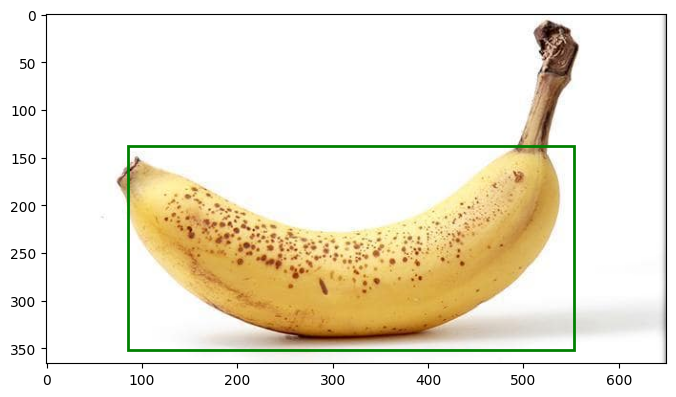

0.41465890407562256
0.2268395870923996
0.19229690730571747
0.17874281108379364
0.15663300454616547
0.13593514263629913
0.1279350221157074
0.11814723163843155
0.10723753273487091
0.10101484507322311
0.08597930520772934
0.06293834000825882
0.05068071186542511


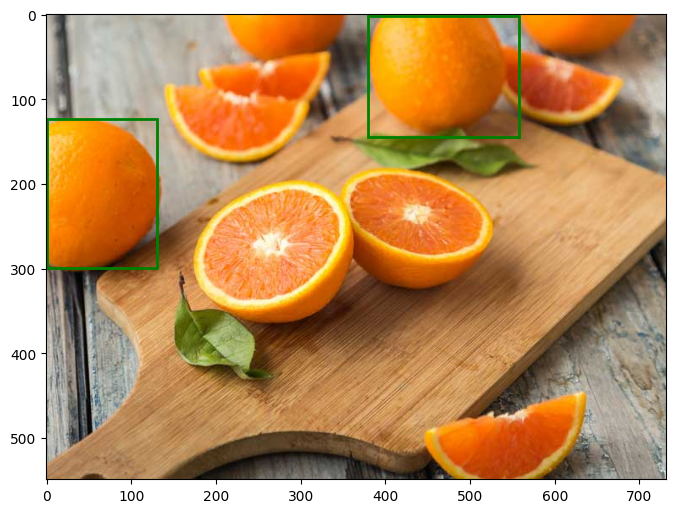

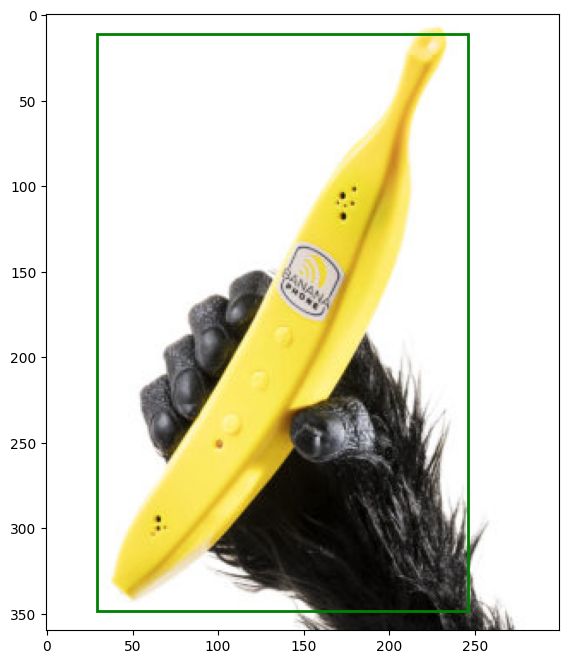

0.7245977520942688
0.2579651176929474


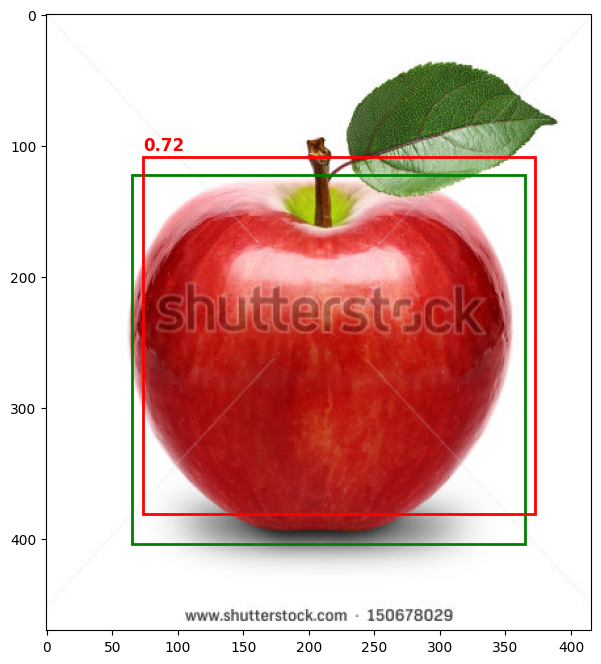

0.8861203193664551
0.42202410101890564
0.3292117118835449
0.20415905117988586
0.1504649966955185
0.05417376011610031


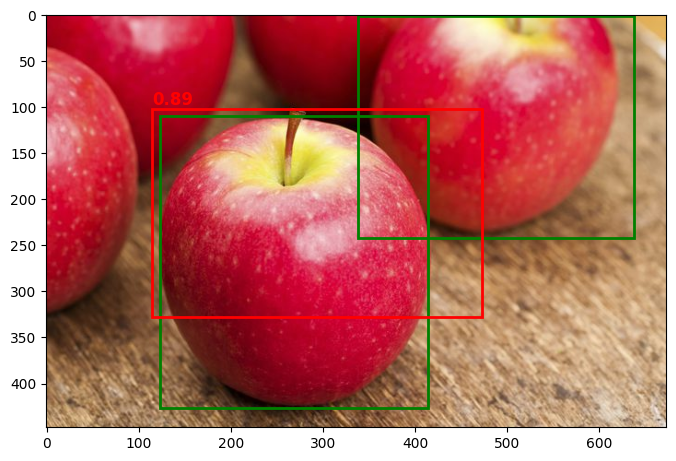

0.6944257020950317
0.2985181510448456
0.20590265095233917


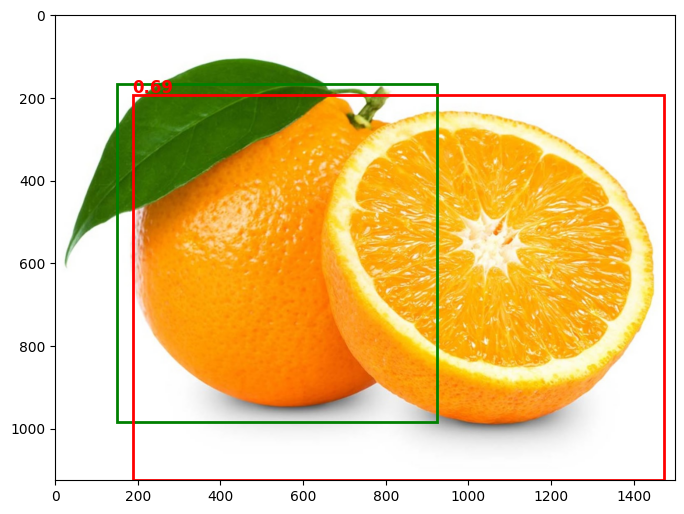

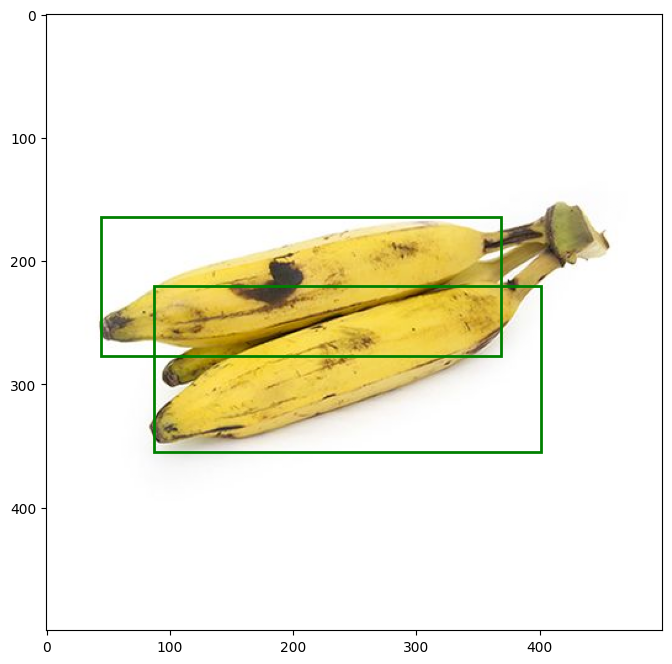

0.4094850420951843
0.34495848417282104
0.28585875034332275
0.2764289379119873


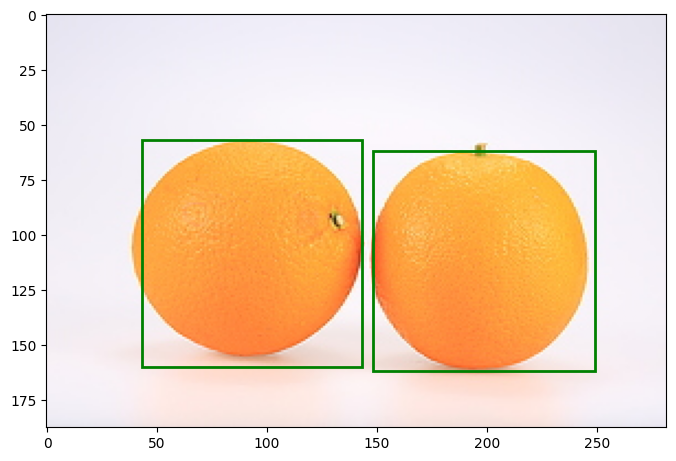

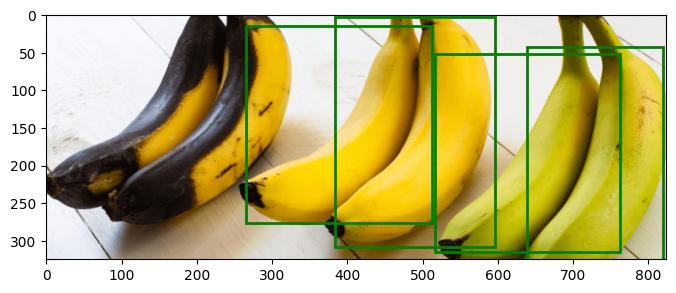

0.6441760063171387
0.42145609855651855


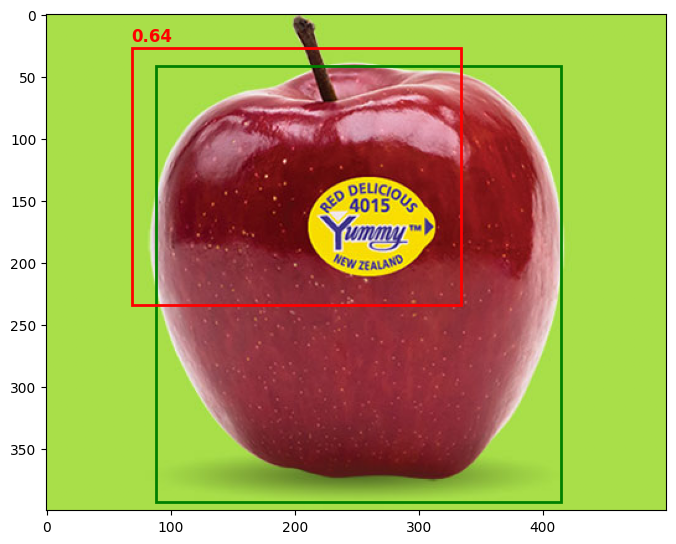

0.36744391918182373
0.15418308973312378
0.06256601959466934


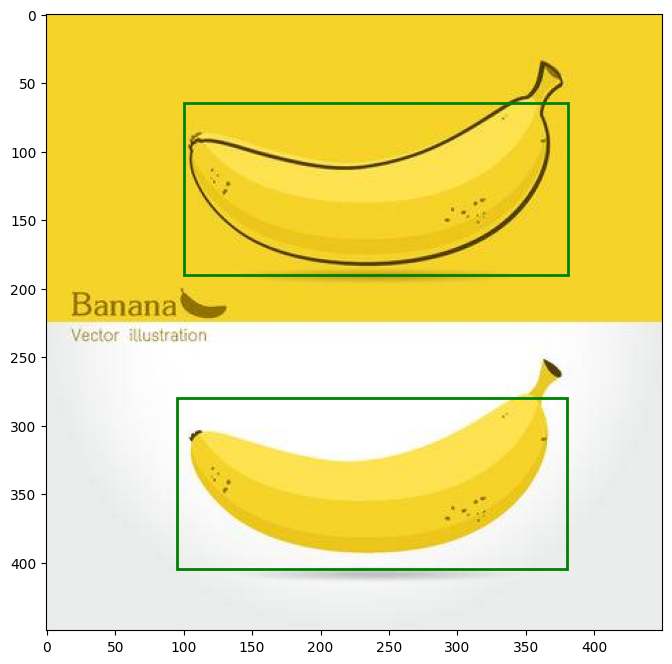

0.3354799747467041
0.1139572486281395


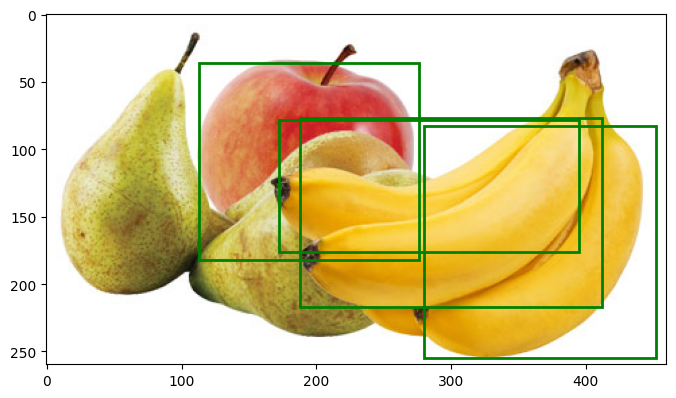

0.8247014284133911
0.21981281042099
0.2038280963897705
0.19955025613307953
0.05633992701768875


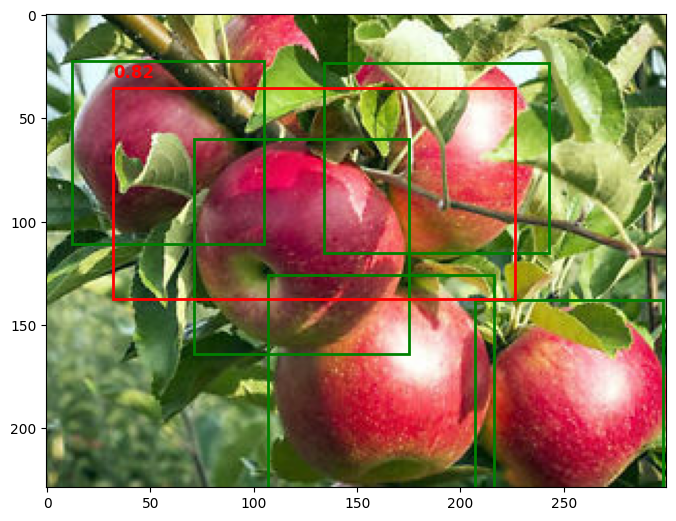

0.31016048789024353
0.06006092578172684


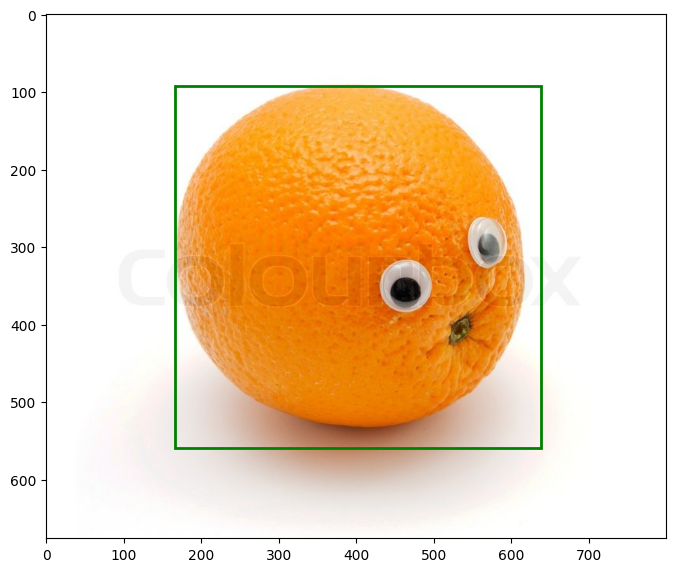

0.8178462982177734
0.13593514263629913
0.10723753273487091
0.10101484507322311
0.06044062599539757


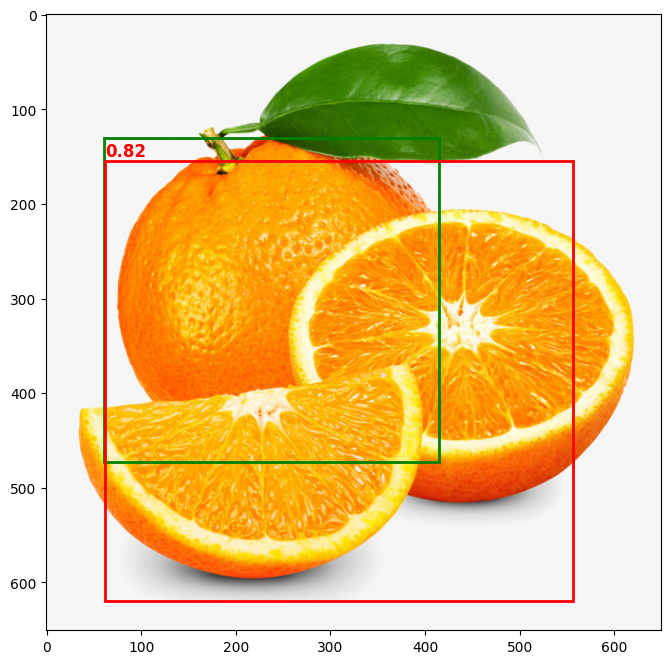

0.33979010581970215
0.27246931195259094
0.19694094359874725
0.13593514263629913
0.10723754018545151
0.10147970914840698
0.1010148674249649


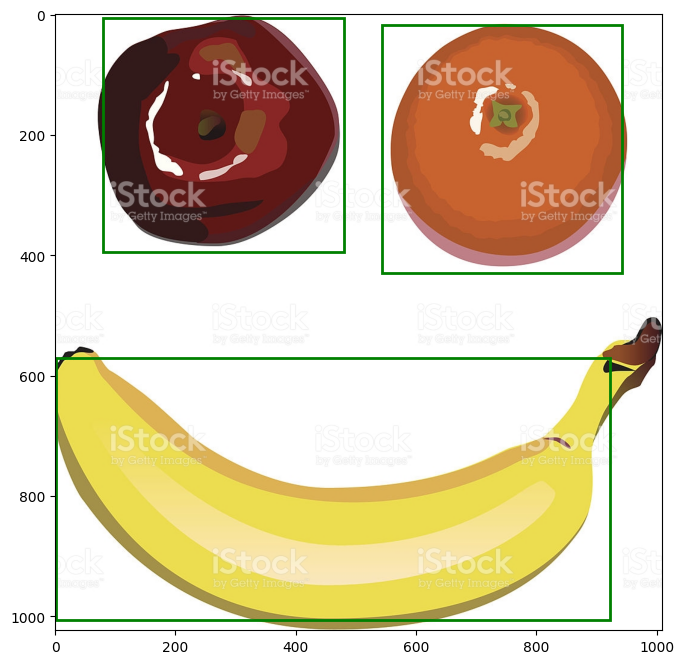

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_output(image, target, prediction):
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image.permute(1, 2, 0).cpu())  # Convert tensor image back to numpy array for display
    
    # Plot target boxes in green
    for box in target['boxes']:
        rect = patches.Rectangle(
            (box[0].item(), box[1].item()), box[2].item() - box[0].item(), box[3].item() - box[1].item(),
            linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
    
    # Plot prediction boxes in red if score > 0.5
    for i, box in enumerate(prediction['boxes']):
        score = prediction['scores'][i].item()
        print(score)
        if score > 0.5:
            rect = patches.Rectangle(
                (box[0].item(), box[1].item()), box[2].item() - box[0].item(), box[3].item() - box[1].item(),
                linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(box[0].item(), box[1].item() - 5, f"{score:.2f}", color='red', fontsize=12, weight='bold')
    
    plt.show()

# Visualize one sample from the evaluation loop

for i, (images, targets)in enumerate(test_loader):
    images = [image.to(device) for image in images]  # Ensure images are tensors and moved to the right device
    predictions = model(images)
    visualize_output(images[0], targets[0], predictions[0])  # Visualize the first image in the batch
    
    if i == 15:
        break